In [1]:
import bioframe as bf
from datasets import load_dataset
from gpn.data import GenomeMSA
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
D = 768
features = [f"embedding_{i}" for i in range(D)]

In [3]:
models = [
    "CADD.RawScore",
    "phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_model = models[-1]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

V = load_dataset("../../results/mpra/processed", split="test").to_pandas()
d = Path(f"../../results/preds/results/mpra/processed")

for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,Tags,DNA,RNA,Value,P-Value,Element,CADD,phyloP-100-vertebrates,GPN-MSA
0,2,60494940,C,A,146,2785,6772,-0.05,0.38889,BCL11A,0.516297,0.727,-0.750451
1,2,60494940,C,G,60,975,2436,-0.13,0.13721,BCL11A,0.499044,0.727,-0.194103
2,2,60494940,C,T,1084,8543,16057,-0.70,0.00000,BCL11A,0.456772,0.727,2.813937
3,2,60494941,C,A,596,9425,23430,-0.08,0.00413,BCL11A,-0.309534,-0.739,-1.609539
4,2,60494941,C,G,75,1506,3697,-0.06,0.47756,BCL11A,-0.326787,-0.739,-1.638036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39165,7,156791602,G,C,358,2279,7044,0.04,0.39490,ZRSh-13h2,-1.231087,-6.461,-7.577469
39166,7,156791602,G,T,1676,12030,37310,0.10,0.00001,ZRSh-13h2,-1.218929,-6.461,-8.451139
39167,7,156791603,C,A,25,107,309,-0.17,0.33374,ZRSh-13h2,-1.201227,-6.793,-9.344140
39168,7,156791603,C,G,654,4748,14458,0.06,0.09092,ZRSh-13h2,-1.218479,-6.793,-8.859602


In [4]:
V = pd.concat([
    V,
    pd.read_parquet(f"../../results/preds/vep_embedding/results/mpra/processed/{embedding_model}.parquet")
], axis=1)
V

,chrom,pos,ref,alt,Tags,DNA,RNA,Value,P-Value,Element,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,2,60494940,C,A,146,2785,6772,-0.05,0.38889,BCL11A,...,63.441223,211.165421,88.467163,139.038055,58.636982,64.378922,52.144745,220.536835,64.319221,151.018555
1,2,60494940,C,G,60,975,2436,-0.13,0.13721,BCL11A,...,64.557976,211.404358,87.581520,137.656799,58.322582,64.309921,54.123390,219.644867,64.318123,150.461212
2,2,60494940,C,T,1084,8543,16057,-0.70,0.00000,BCL11A,...,63.264294,210.984650,88.472443,138.607727,58.385876,64.242477,52.257622,220.454681,64.424507,150.459625
3,2,60494941,C,A,596,9425,23430,-0.08,0.00413,BCL11A,...,63.932457,210.537048,87.865448,136.487137,57.896053,64.972626,52.148781,220.781677,64.208206,151.767303
4,2,60494941,C,G,75,1506,3697,-0.06,0.47756,BCL11A,...,64.183243,210.046417,87.352142,133.656326,57.697662,64.733788,53.094517,220.671982,63.315155,151.463043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39165,7,156791602,G,C,358,2279,7044,0.04,0.39490,ZRSh-13h2,...,83.081512,54.195293,49.368298,190.228699,57.383709,147.361298,68.176964,68.698425,110.280602,91.955429
39166,7,156791602,G,T,1676,12030,37310,0.10,0.00001,ZRSh-13h2,...,83.403183,54.399376,49.504349,187.856949,57.645309,147.346848,67.231705,68.642998,111.292778,92.353760
39167,7,156791603,C,A,25,107,309,-0.17,0.33374,ZRSh-13h2,...,82.373734,53.482254,49.978306,185.597412,58.625378,151.944092,68.456589,70.391617,111.369461,92.683594
39168,7,156791603,C,G,654,4748,14458,0.06,0.09092,ZRSh-13h2,...,82.755409,53.353920,49.569927,185.625854,58.503178,151.530014,68.485046,70.256500,109.672089,92.876968


In [5]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [6]:
# Intersection is only 126
"""
enformer = pd.read_parquet("../../results/enformer/merged.correct_ref_alt.parquet")
cols = ["chrom", "pos", "ref", "alt"]
V = V.merge(enformer, on=cols, how="inner")
models += [
    "Enformer_l2",
    #"Enformer_l1",
    #"Enformer_linf",
]
V
""";

In [7]:
V.dropna(subset=models, inplace=True)
V.shape

(39170, 781)

In [8]:
V["label"] = V.Value.abs()

In [9]:
def train_predict_best_inner_product(V_train, V_test):
    results_train = pd.DataFrame([
        [f, spearmanr(V_train.label, -V_train[f])[0]]
        for f in features
    ], columns=["Model", "Spearman"]).sort_values("Spearman", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', RidgeCV(
            alphas=[1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    #print(clf.named_steps["linear"].alpha_)
    return -clf.predict(V_test[features])

supervised_models = [
    #("Best inner product", train_predict_best_inner_product),
    ("LR(inner products)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features)),
    #("LR(inner products + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["Enformer_l2"])),
    #("LR(inner products + LLR)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA"])),
    #("LR(inner products + LLR + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA", "Enformer_l2"])),
]

def train_predict_lr_split(V, model_name, model):
    all_pos = np.unique(V.pos)  # sorted
    splits = [all_pos[::2], all_pos[1::2]]
    for split in splits:
        mask_train = V.pos.isin(split)
        mask_test = ~mask_train
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])
    return V[model_name].values
        

for Element in tqdm(V.Element.unique()):
    V_e = V[V.Element==Element]
    y = V_e.Value.abs()
    for m, model in supervised_models:
        V.loc[V.Element==Element, m] = train_predict_lr_split(V_e, m, model)
        if m not in models: models.append(m)
V

100%|██████████| 29/29 [00:06<00:00,  4.35it/s]


,chrom,pos,ref,alt,Tags,DNA,RNA,Value,P-Value,Element,...,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,label,LR(inner products)
0,2,60494940,C,A,146,2785,6772,-0.05,0.38889,BCL11A,...,88.467163,139.038055,58.636982,64.378922,52.144745,220.536835,64.319221,151.018555,0.05,-0.047911
1,2,60494940,C,G,60,975,2436,-0.13,0.13721,BCL11A,...,87.581520,137.656799,58.322582,64.309921,54.123390,219.644867,64.318123,150.461212,0.13,-0.048028
2,2,60494940,C,T,1084,8543,16057,-0.70,0.00000,BCL11A,...,88.472443,138.607727,58.385876,64.242477,52.257622,220.454681,64.424507,150.459625,0.70,-0.047724
3,2,60494941,C,A,596,9425,23430,-0.08,0.00413,BCL11A,...,87.865448,136.487137,57.896053,64.972626,52.148781,220.781677,64.208206,151.767303,0.08,-0.092563
4,2,60494941,C,G,75,1506,3697,-0.06,0.47756,BCL11A,...,87.352142,133.656326,57.697662,64.733788,53.094517,220.671982,63.315155,151.463043,0.06,-0.092231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39165,7,156791602,G,C,358,2279,7044,0.04,0.39490,ZRSh-13h2,...,49.368298,190.228699,57.383709,147.361298,68.176964,68.698425,110.280602,91.955429,0.04,-0.062691
39166,7,156791602,G,T,1676,12030,37310,0.10,0.00001,ZRSh-13h2,...,49.504349,187.856949,57.645309,147.346848,67.231705,68.642998,111.292778,92.353760,0.10,-0.062872
39167,7,156791603,C,A,25,107,309,-0.17,0.33374,ZRSh-13h2,...,49.978306,185.597412,58.625378,151.944092,68.456589,70.391617,111.369461,92.683594,0.17,-0.058924
39168,7,156791603,C,G,654,4748,14458,0.06,0.09092,ZRSh-13h2,...,49.569927,185.625854,58.503178,151.530014,68.485046,70.256500,109.672089,92.876968,0.06,-0.058565


## Testing

In [10]:
rows = []
for Element in tqdm(V.Element.unique()):
    V_e = V[V.Element==Element]
    y = V_e.Value.abs()
    for m in models:
        x = -V_e[m]
        rows.append([
            Element,
            m,
            pearsonr(x, y)[0],
            spearmanr(x, y)[0],
        ])
results = pd.DataFrame(rows, columns=["Element", "Model", "Pearson", "Spearman"])
results

100%|██████████| 29/29 [00:00<00:00, 134.10it/s]


,Element,Model,Pearson,Spearman
0,BCL11A,CADD,-0.053092,-0.042830
1,BCL11A,phyloP-100-vertebrates,-0.021894,-0.004669
2,BCL11A,GPN-MSA,0.016952,0.018369
3,BCL11A,LR(inner products),0.087145,0.095749
4,F9,CADD,0.001415,0.031064
...,...,...,...,...
111,ZRSh-13,LR(inner products),0.236292,0.222705
112,ZRSh-13h2,CADD,-0.014242,-0.055486
113,ZRSh-13h2,phyloP-100-vertebrates,0.027571,-0.005961
114,ZRSh-13h2,GPN-MSA,0.049293,0.025431


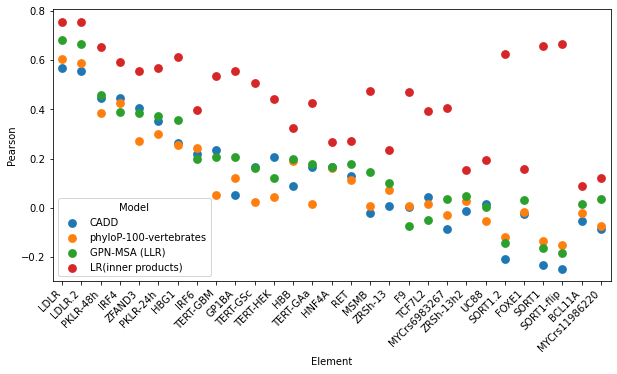

In [11]:
plt.figure(figsize=(10, 5))
g = sns.pointplot(
    data=results.replace({"GPN-MSA": "GPN-MSA (LLR)"}),
    hue="Model",
    x="Element",
    y="Pearson",  # "Spearman" or "Pearson"
    join=False,
    order=results.groupby("Element").Pearson.mean().sort_values(ascending=False).index.values,
);
plt.xticks(rotation=45, ha="right");
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));